In [1]:
import os
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore') #, category=RuntimeWarning) # , category=FutureWarning)


from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask
import dask.array as da

import itertools

from collections import OrderedDict

import inout as io
import gridop as gop
import diags as dg
import plot as cplt
from model import Model
from tools import wait_cluster_ready

### Launch dask cluster

In [2]:
from dask.distributed import Client, LocalCluster

# number of cores per node
workers_per_job = 4
# number of nodes
jobs = 2
nworkers = workers_per_job * jobs

# type of cluster
config = 1

if config==1:
    # pour 1 seul noeud
    cluster = LocalCluster(n_workers=2, threads_per_worker=2)
    client = Client(cluster)
else:
    # pour plusieurs noeuds:
    # ** processes and cores may be adjusted in order to have more memory 
    # or inversely more computational ressource
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=workers_per_job, cores=workers_per_job, walltime='02:00:00')
    w = cluster.scale(jobs=jobs)
    #cluster.adapt(minimum=1, maximum=5)

    client = Client(cluster)
    wait_cluster_ready(cluster, nworkers)
    
# put tmp files of dask in the scratch directory
try:
    scratch = os.environ['SCRATCH']
except:
    scratch = os.environ['HOME']
dask.config.set(local_directory=scratch)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 110.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40034,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 110.00 GiB
Comm: tcp://127.0.0.1:47065,Total threads: 2
Dashboard: http://127.0.0.1:47786/status,Memory: 55.00 GiB
Nanny: tcp://127.0.0.1:50841,


---
### Parameters

In [3]:
# Initialisation mozambique 
path = "/home/datawork-lops-osi/slgentil/data/moz/"
filenames = [path+"moz_his.nc"]
gridname = path+"moz_his.nc"
longitude = 39.
latitude = -21.
depth = -100.
seldate = '2000-01-13'
model = "croco_xios"

# # Initialisation benguela
# path = "/home/datawork-lops-osi/slgentil/data/"
# filenames = [path+"pierrick.nc"]
# gridname = path+"pierrick.nc"
# longitude = 42.5
# latitude = -21.
# depth = -100.
# seldate = '4.726e+07'
# model = "croco_native"
# drop_variables = ['nav_lon_w', 'nav_lat_w',
#                   'sustr', 'svstr','bvf',
#                   'hc','h','Vtransform','sc_r','sc_w',
#                   'Cs_r','Cs_w','angle','mask_rho',
#                   'pm','pn','Tcline','theta_s','theta_b',
#                   'lon_rho','lat_rho','lon_u','lat_u','lon_v','lat_v',
#                   'nav_lon_rho','nav_lat_rho','nav_lon_u','nav_lat_u','nav_lon_v','nav_lat_v',
#                   'time_instant','time_instant_bounds',
#                   'time_counter_bounds',
#                  ]

# Initialisation gigatl6
# path = "/home/datawork-lops-osi/slgentil/data/gigatl6/"
# filenames = [path+'GIGATL6_12h_inst_2005-12-20-2005-12-24.nc']
# gridname  = '/home/datawork-lops-megatl/GIGATL6/gigatl6_grd.nc'
# longitude = -25.
# latitude = 0.
# depth = -100.
# # deltat = None
# seldate = '2005-12-25'
# model = "croco_xios"


--- 
### Create an instance of the Model class 
which contains all the substitutions of the variables names depending on the model: 
- croco_xios

In [4]:
croco = Model(model)

### Open all the data files and the grid file and return a dataset. Create the xgcm grid.

In [5]:
%%time
drop_variables = [] 
ds, grid = io.open_files(croco, gridname, filenames, grid_metrics=1, 
                          drop_variables=drop_variables,
                          chunks={'t':1},
                          # chunks={'t':1, 's':1, 's_w':1},
                         )

CPU times: user 256 ms, sys: 28 ms, total: 284 ms
Wall time: 986 ms


In [6]:
ds

<xarray.Dataset>
Dimensions:              (y: 256, x: 256, s: 120, s_w: 121, x_u: 257, y_v: 257,
                          t: 13, axis_nbounds: 2)
Coordinates:
    lat                  (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    lon                  (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
  * s                    (s) float32 -0.9958 -0.9875 ... -0.0125 -0.004167
  * s_w                  (s_w) float32 -1.0 -0.9917 -0.9833 ... -0.008333 0.0
    lat_u                (y, x_u) float32 dask.array<chunksize=(256, 257), meta=np.ndarray>
    lon_u                (y, x_u) float32 dask.array<chunksize=(256, 257), meta=np.ndarray>
    lat_v                (y_v, x) float32 dask.array<chunksize=(257, 256), meta=np.ndarray>
    lon_v                (y_v, x) float32 dask.array<chunksize=(257, 256), meta=np.ndarray>
  * t                    (t) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-1...
    lon_f                (y_v, x_u) float32 dask.array<chunksize=(257, 257), meta=np.ndarray>
    lat_f                (y_v, x_u) float32 dask.array<chunksize=(257, 257), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v, axis_nbounds
Data variables: (12/37)
    nav_lat_1point       float32 dask.array<chunksize=(), meta=np.ndarray>
    nav_lon_1point       float32 dask.array<chunksize=(), meta=np.ndarray>
    nav_lat_w            (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    nav_lon_w            (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    hc                   float32 ...
    theta_s              (t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                   ...
    zdiff_mtm_w          (t, s_w, y, x) float32 dask.array<chunksize=(1, 121, 256, 256), meta=np.ndarray>
    zdiff_tra_w          (t, s_w, y, x) float32 dask.array<chunksize=(1, 121, 256, 256), meta=np.ndarray>
    dx                   (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dy                   (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dx_u                 (y, x_u) float32 dask.array<chunksize=(256, 257), meta=np.ndarray>
    dy_v                 (y_v, x) float32 dask.array<chunksize=(257, 256), meta=np.ndarray>
Attributes:
    name:         CROCO_FILES/moz
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2018-Jan-29 11:37:17 CET

In [7]:
%%time
ds1 = ds.sel(t=seldate, method='nearest')
ds1

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.85 ms


<xarray.Dataset>
Dimensions:              (y: 256, x: 256, s: 120, s_w: 121, x_u: 257, y_v: 257,
                          axis_nbounds: 2)
Coordinates:
    lat                  (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    lon                  (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
  * s                    (s) float32 -0.9958 -0.9875 ... -0.0125 -0.004167
  * s_w                  (s_w) float32 -1.0 -0.9917 -0.9833 ... -0.008333 0.0
    lat_u                (y, x_u) float32 dask.array<chunksize=(256, 257), meta=np.ndarray>
    lon_u                (y, x_u) float32 dask.array<chunksize=(256, 257), meta=np.ndarray>
    lat_v                (y_v, x) float32 dask.array<chunksize=(257, 256), meta=np.ndarray>
    lon_v                (y_v, x) float32 dask.array<chunksize=(257, 256), meta=np.ndarray>
    t                    datetime64[ns] 2000-01-13T12:00:00
    lon_f                (y_v, x_u) float32 dask.array<chunksize=(257, 257), meta=np.ndarray>
    lat_f                (y_v, x_u) float32 dask.array<chunksize=(257, 257), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v, axis_nbounds
Data variables: (12/37)
    nav_lat_1point       float32 dask.array<chunksize=(), meta=np.ndarray>
    nav_lon_1point       float32 dask.array<chunksize=(), meta=np.ndarray>
    nav_lat_w            (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    nav_lon_w            (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    hc                   float32 ...
    theta_s              float32 dask.array<chunksize=(), meta=np.ndarray>
    ...                   ...
    zdiff_mtm_w          (s_w, y, x) float32 dask.array<chunksize=(121, 256, 256), meta=np.ndarray>
    zdiff_tra_w          (s_w, y, x) float32 dask.array<chunksize=(121, 256, 256), meta=np.ndarray>
    dx                   (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dy                   (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dx_u                 (y, x_u) float32 dask.array<chunksize=(256, 257), meta=np.ndarray>
    dy_v                 (y_v, x) float32 dask.array<chunksize=(257, 256), meta=np.ndarray>
Attributes:
    name:         CROCO_FILES/moz
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2018-Jan-29 11:37:17 CET

### U slice at a constant depth

CPU times: user 380 ms, sys: 28 ms, total: 408 ms
Wall time: 7.8 s


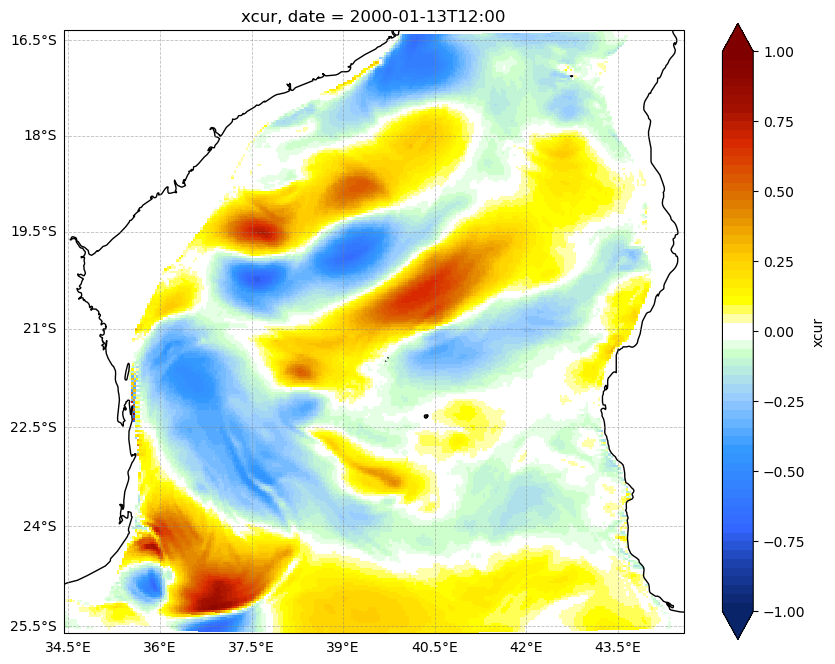

In [8]:
%%time
# depths at u points
z_u = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='u')
# slice of u at a constant depth
uslice= gop.slices(croco, ds1.xcur, z_u, ds=ds1, depth=depth)
# plot the slice of u
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(uslice, **kwargs)

### V slice at a constant depth

In [9]:
%%time
# depth at v points
z_v = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, hgrid='v')
# slice of v at a constant depth
# v=ds1.ycur
# v=gop.auto_chunk(v, keep_complete_dim='s', wanted_chunk=200)
vslice= gop.slices(croco, ds1.ycur, z_v, ds=ds1, depth=depth).compute()
# plot the v slice
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(vslice, **kwargs)

distributed.worker - WARNING - Compute Failed
Key:       ('xarray-h-91bf807281e33ba8959ac2350cb06c70', 0, 0)
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=MemoryCachedArray(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x2aaad8e01100>, key=BasicIndexer((slice(1, 257, 1), slice(1, 257, 1))))))), (slice(0, 256, None), slice(0, 256, None)))
kwargs:    {}
Exception: "RuntimeError('NetCDF: HDF error')"



RuntimeError: NetCDF: HDF error

### Rotate u,v to lat,lon coord

In [10]:
%%time
# depth at rho points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
aslice= ds1.angle
# compute u_EW and v_SN
[urot,vrot] = gop.rotuv(croco, ds1, u=uslice, v=vslice, angle=aslice)

NameError: name 'vslice' is not defined

### Compute relative vorticity

In [11]:
%%time
# compute the relative vorticity at a constant depth
relvort = dg.relative_vorticity_z(croco, ds=ds1, xgrid=grid, u=uslice, v=vslice)
# plot the relative vorticity
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(relvort, **kwargs)

NameError: name 'vslice' is not defined

### Compute dtemp/dz on a longitudinal slice

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
Exception ignored in: <function CachingFileManager.__del__ at 0x2aaac43c0dc0>
Traceback (most recent call last):
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 249, in __del__
    self.close(needs_lock=False)
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 233, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2624, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2587, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2028, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


CPU times: user 180 ms, sys: 8 ms, total: 188 ms
Wall time: 501 ms


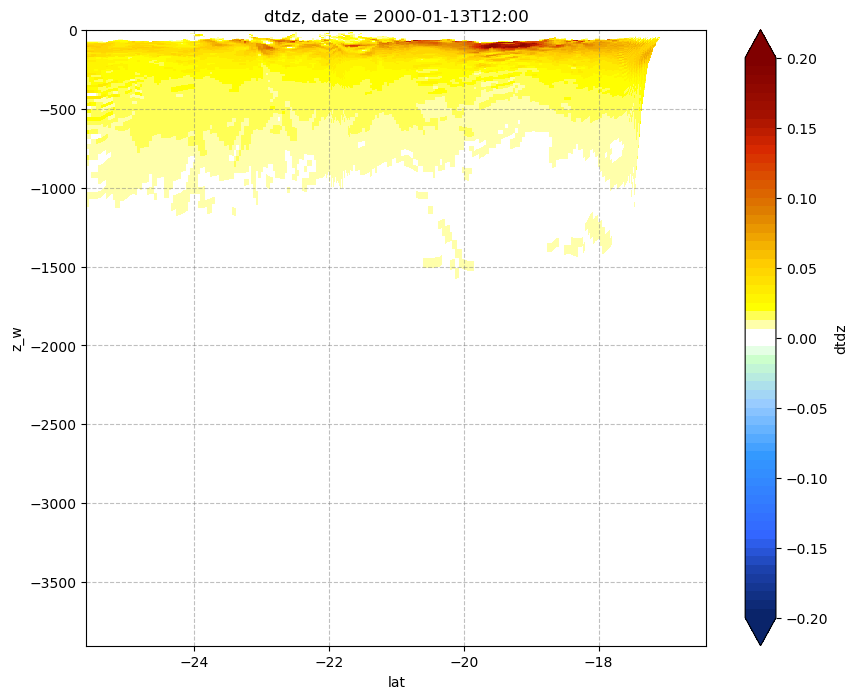

In [12]:
%%time
# longitudinal slice of temperature
tslice = gop.slices(croco, ds1.temp, z, ds=ds1, longitude=longitude)
# compute dtemp/dz
dtdz = dg.dtempdz(croco, ds=ds1, temp=tslice, z=tslice.z)
# plot dtemp/dz
kwargs = {'vmin': -0.2, 'vmax': 0.2, 'extend':'both'}
cplt.plotfig(dtdz, **kwargs)

### Compute Richardson on a longitudinal slice

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 336 ms, sys: 116 ms, total: 452 ms
Wall time: 783 ms


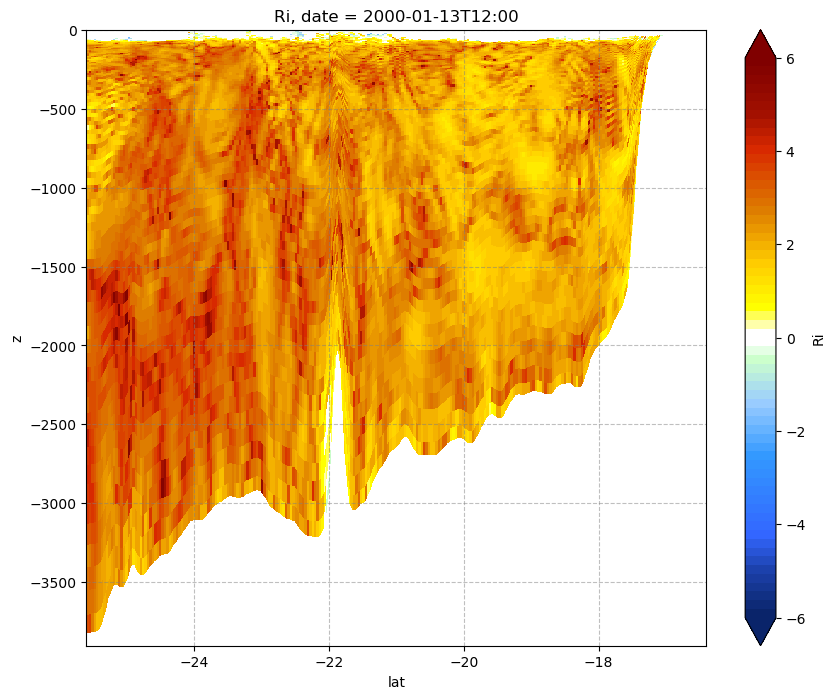

In [13]:
%%time
# longitudinal slices of rho,u,v
rslice = gop.slices(croco, ds1.rho, z, ds=ds1, longitude=longitude)
uslice = gop.slices(croco, ds1.xcur, z_u, ds=ds1, longitude=longitude)
vslice = gop.slices(croco, ds1.ycur, z_v, ds=ds1, longitude=longitude)
# compute the Richardson number
Ri = dg.richardson(croco, ds=ds1, u=uslice, v=vslice, rho=rslice, z=rslice.z)
# plot the Richardson number
kwargs = {'vmin': -6., 'vmax': 6., 'extend':'both'}
cplt.plotfig(Ri, **kwargs)

### Compute the Pressure

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 412 ms, sys: 92 ms, total: 504 ms
Wall time: 1.61 s


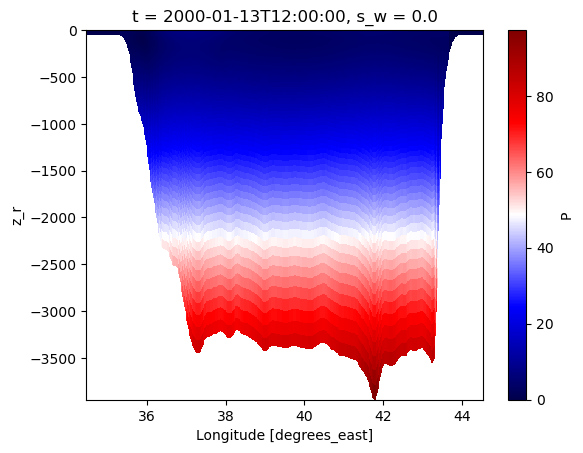

In [14]:
%%time
# depth at rho points and w points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
z_w = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='w')
# compute the pressure
P = dg.get_p(croco, ds1.rho, z_w, z, ds=ds1)
# plot the pressure
coords = gop.get_spatial_coords(P)
P.isel(y=int(P.y.size/8)).plot(x=coords['lon'], y=coords['z'], cmap="seismic")

CPU times: user 856 ms, sys: 4 ms, total: 860 ms
Wall time: 2.18 s


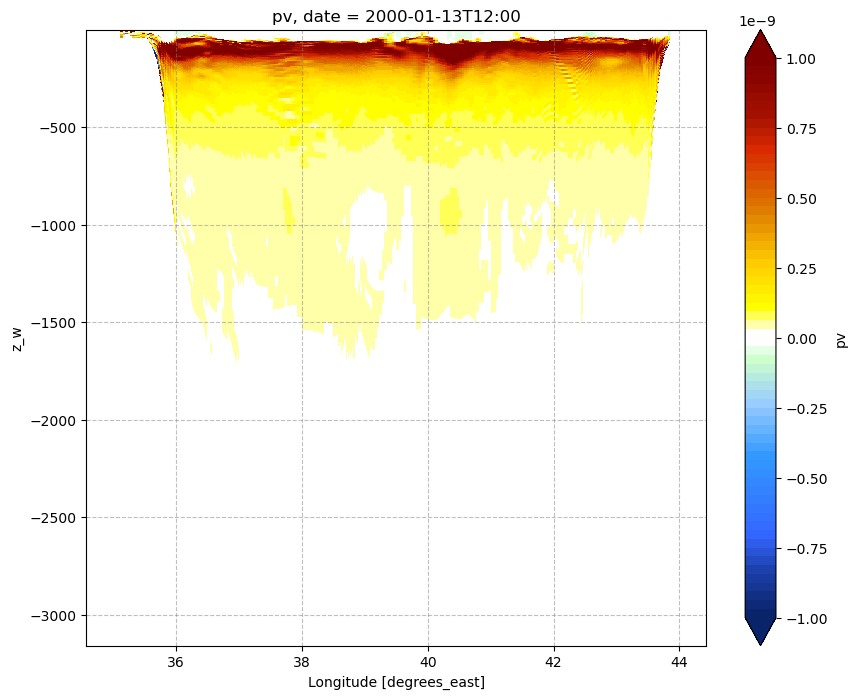

In [15]:
%%time
pv = dg.ertel_pv(croco, ds=ds1, typ='ijk')
kwargs = {'vmin': -1.e-9, 'vmax': 1.e-9, 'extend':'both'}
cplt.plotfig(pv.isel(y=128), **kwargs)


In [16]:
cluster.close()